# Cat and Dog Classification - week 5
Classify images of cats and dogs using Histogram of Oriented Gradients (HOG) for feature extraction and Decision Tree, Random Forest, Linear Regression for classification and compair them. 

In [13]:
import os # For file and directory operations
import numpy as np # For numerical computations and array handling
from skimage.io import imread # For reading images from files
from skimage.color import rgb2gray  # For converting images to grayscale
from skimage.feature import hog # For extracting HOG (Histogram of Oriented Gradients) features
from sklearn.model_selection import train_test_split, learning_curve  # For splitting data and plotting learning curves
from sklearn.tree import DecisionTreeClassifier # For classification using Decision Trees
from sklearn.ensemble import RandomForestClassifier, VotingClassifier # For ensemble learning (Random Forest, Voting)
from sklearn.linear_model import LinearRegression, LogisticRegression # For regression and classification models
from sklearn.svm import SVC # For classification using Support Vector Machines
from sklearn.neighbors import KNeighborsClassifier # For classification using k-Nearest Neighbors
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay # For evaluating and visualizing model performance
from sklearn.base import BaseEstimator, ClassifierMixin # For creating custom classifiers
import matplotlib.pyplot as plt # For plotting graphs and visualizations

In [14]:
# Load dataset
data_dir = './dataset'
images, labels = [], [] # Lists to store images and their corresponding labels

for file in os.listdir(data_dir):
    if file.endswith('.jpg'):  # Only process .jpg image files
        img_path = os.path.join(data_dir, file) # Get full file path
        if file.startswith('cat'):
            labels.append(0)  # Assign label 0 for cat images
        elif file.startswith('dog'):
            labels.append(1)  # Assign label 1 for dog images
        else:
            continue

        img = imread(img_path)
        img = rgb2gray(img)  # Convert to grayscale
        images.append(img) # Add the processed image to the images list

images = np.array(images) # Convert list of images to a NumPy array
labels = np.array(labels) # Convert list of labels to a NumPy array
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print(f'Number of cats: {np.sum(labels == 0)}')
print(f'Number of dogs: {np.sum(labels == 1)}')

Images shape: (615, 128, 128)
Labels shape: (615,)
Number of cats: 260
Number of dogs: 355


In [15]:
# Extract HOG features
hog_features = [] # List to store HOG feature vectors
hog_images = [] # List to store HOG visualization images
for img in images:
    features, hog_img = hog(
        img,
        orientations=9, # Number of orientation bins for gradient directions
        pixels_per_cell=(8, 8), # Size of each cell in pixels
        cells_per_block=(2, 2), # Number of cells per block
        block_norm='L2-Hys', # Normalization method for blocks
        transform_sqrt=True, # Apply square root transformation for better contrast
        visualize=True # Return HOG image for visualization
    )
    hog_features.append(features)
    hog_images.append(hog_img)

hog_features = np.array(hog_features) # Convert list of HOG features to a NumPy array
hog_images = np.array(hog_images) # Convert list of HOG images to a NumPy array
print('HOG features shape:', hog_features.shape)
print('HOG images shape:', hog_images.shape)

HOG features shape: (615, 8100)
HOG images shape: (615, 128, 128)


In [16]:
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    hog_features, # Features (HOG vectors) to split
    labels, # Corresponding labels
    np.arange(len(labels)), # Indices of all samples (to split images later)
    test_size=0.2, # 20% of data for testing, 80% for training
    random_state=42, # Seed for reproducibility
    stratify=labels # Keep class distribution same in train and test sets
)
images_train = images[idx_train] # Training images (original grayscale)
images_test = images[idx_test] # Test images (original grayscale)
hog_images_train = hog_images[idx_train] # Training HOG visualization images
hog_images_test = hog_images[idx_test] # Test HOG visualization images

print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
print(f'Training set - Cats: {np.sum(y_train == 0)}, Dogs: {np.sum(y_train == 1)}')
print(f'Test set - Cats: {np.sum(y_test == 0)}, Dogs: {np.sum(y_test == 1)}')

Training set shape: (492, 8100)
Test set shape: (123, 8100)
Training set - Cats: 208, Dogs: 284
Test set - Cats: 52, Dogs: 71


In [17]:
# Wrapper for Linear Regression
class LinearRegressionClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self): 
        self.model = LinearRegression() # Initialize a Linear Regression model to be used as a classifier

    def fit(self, X, y):
        self.model.fit(X, y) # Train the linear regression model on features X and labels y
        return self # Return self to allow chaining (required by sklearn interface)
    
    def predict(self, X):
        return (self.model.predict(X) >= 0.5).astype(int) # Predict continuous values and convert them to 0 or 1 based on threshold 0.5

In [18]:
# Train models using scikit learn
# Decision Tree
dt = DecisionTreeClassifier(random_state=42) # Initialize Decision Tree classifier
dt.fit(X_train, y_train) # Train on training data
dt_pred = dt.predict(X_test) # Predict on test data
dt_accuracy = accuracy_score(y_test, dt_pred) # Calculate accuracy

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42) # Initialize Random Forest with 100 trees
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)

# Linear Regression
lr = LinearRegressionClassifier() # Initialize custom Linear Regression classifier
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

# Logistic Regression
logreg = LogisticRegression(max_iter=1000, random_state=42) # Initialize Logistic Regression classifier
logreg.fit(X_train, y_train)
logreg_pred = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_pred)

# SVM
svm = SVC(kernel='linear', random_state=42) # Initialize linear SVM classifier
svm.fit(X_train, y_train)
svm_pred = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

# KNN
knn = KNeighborsClassifier(n_neighbors=5) # Initialize k-Nearest Neighbors classifier with k=5
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)

# Voting
voting_logreg = VotingClassifier(
    estimators=[('dt', dt), ('rf', rf), ('logreg', logreg)], # Combine DT, RF, and Logistic Regression
    voting='hard' # Use majority voting for final prediction
)
voting_logreg.fit(X_train, y_train) # Train ensemble on training data
voting_logreg_pred = voting_logreg.predict(X_test) # Predict on test data
voting_logreg_accuracy = accuracy_score(y_test, voting_logreg_pred) # Calculate accuracy

# Print accuracies
print(f"Decision Tree Accuracy: {dt_accuracy:.4f}")
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")
print(f"Linear Regression Accuracy: {lr_accuracy:.4f}")
print(f"Logistic Regression Accuracy: {logreg_accuracy:.4f}")
print(f"SVM Accuracy: {svm_accuracy:.4f}")
print(f"KNN Accuracy: {knn_accuracy:.4f}")
print(f"Voting Accuracy: {voting_logreg_accuracy:.4f}")

Decision Tree Accuracy: 0.8130
Random Forest Accuracy: 0.9350
Linear Regression Accuracy: 0.9106
Logistic Regression Accuracy: 0.9268
SVM Accuracy: 0.9268
KNN Accuracy: 0.6016
Voting Accuracy: 0.9350


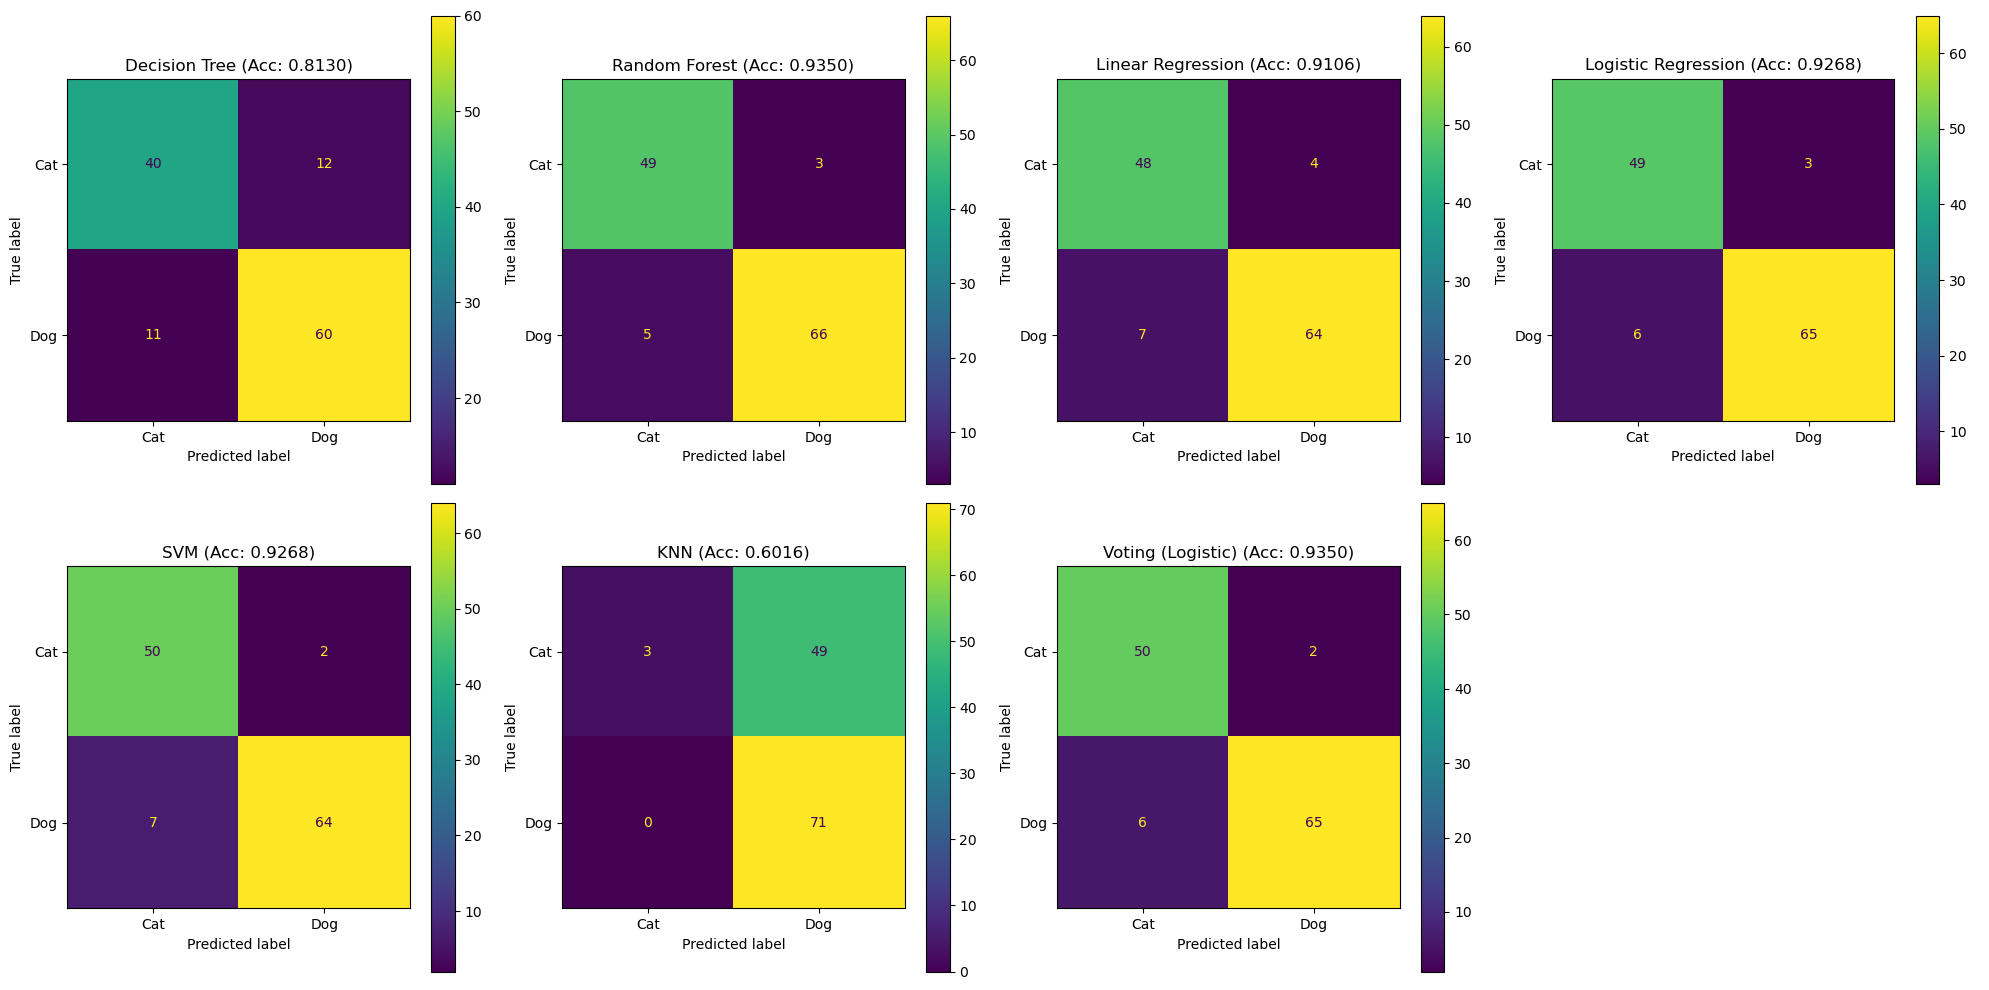

In [20]:
# Compare models with confusion matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))  # Create a 2x4 grid for plotting confusion matrices
axes = axes.ravel()  # Flatten axes array for easier indexing

# Decision Tree
cm_dt = confusion_matrix(y_test, dt_pred)  # Compute confusion matrix for Decision Tree
ConfusionMatrixDisplay(cm_dt, display_labels=['Cat', 'Dog']).plot(ax=axes[0], values_format='d')  # Display confusion matrix on subplot
axes[0].set_title(f'Decision Tree (Acc: {dt_accuracy:.4f})')  # Set title with accuracy

# Random Forest
cm_rf = confusion_matrix(y_test, rf_pred)  # Compute confusion matrix for Random Forest
ConfusionMatrixDisplay(cm_rf, display_labels=['Cat', 'Dog']).plot(ax=axes[1], values_format='d')
axes[1].set_title(f'Random Forest (Acc: {rf_accuracy:.4f})')

# Linear Regression
cm_lr = confusion_matrix(y_test, lr_pred)  # Compute confusion matrix for Linear Regression
ConfusionMatrixDisplay(cm_lr, display_labels=['Cat', 'Dog']).plot(ax=axes[2], values_format='d')
axes[2].set_title(f'Linear Regression (Acc: {lr_accuracy:.4f})')

# Logistic Regression
cm_logreg = confusion_matrix(y_test, logreg_pred)  # Compute confusion matrix for Logistic Regression
ConfusionMatrixDisplay(cm_logreg, display_labels=['Cat', 'Dog']).plot(ax=axes[3], values_format='d')
axes[3].set_title(f'Logistic Regression (Acc: {logreg_accuracy:.4f})')

# SVM
cm_svm = confusion_matrix(y_test, svm_pred)  # Compute confusion matrix for SVM
ConfusionMatrixDisplay(cm_svm, display_labels=['Cat', 'Dog']).plot(ax=axes[4], values_format='d')
axes[4].set_title(f'SVM (Acc: {svm_accuracy:.4f})')

# KNN
cm_knn = confusion_matrix(y_test, knn_pred)  # Compute confusion matrix for KNN
ConfusionMatrixDisplay(cm_knn, display_labels=['Cat', 'Dog']).plot(ax=axes[5], values_format='d')
axes[5].set_title(f'KNN (Acc: {knn_accuracy:.4f})')

# Voting (Logistic)
cm_voting_logreg = confusion_matrix(y_test, voting_logreg_pred)  # Compute confusion matrix for Voting ensemble with Logistic Regression
ConfusionMatrixDisplay(cm_voting_logreg, display_labels=['Cat', 'Dog']).plot(ax=axes[6], values_format='d')
axes[6].set_title(f'Voting (Logistic) (Acc: {voting_logreg_accuracy:.4f})')

# Hide the last empty subplot (axes[7]) since we're not using it
axes[7].axis('off')

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display all confusion matrices


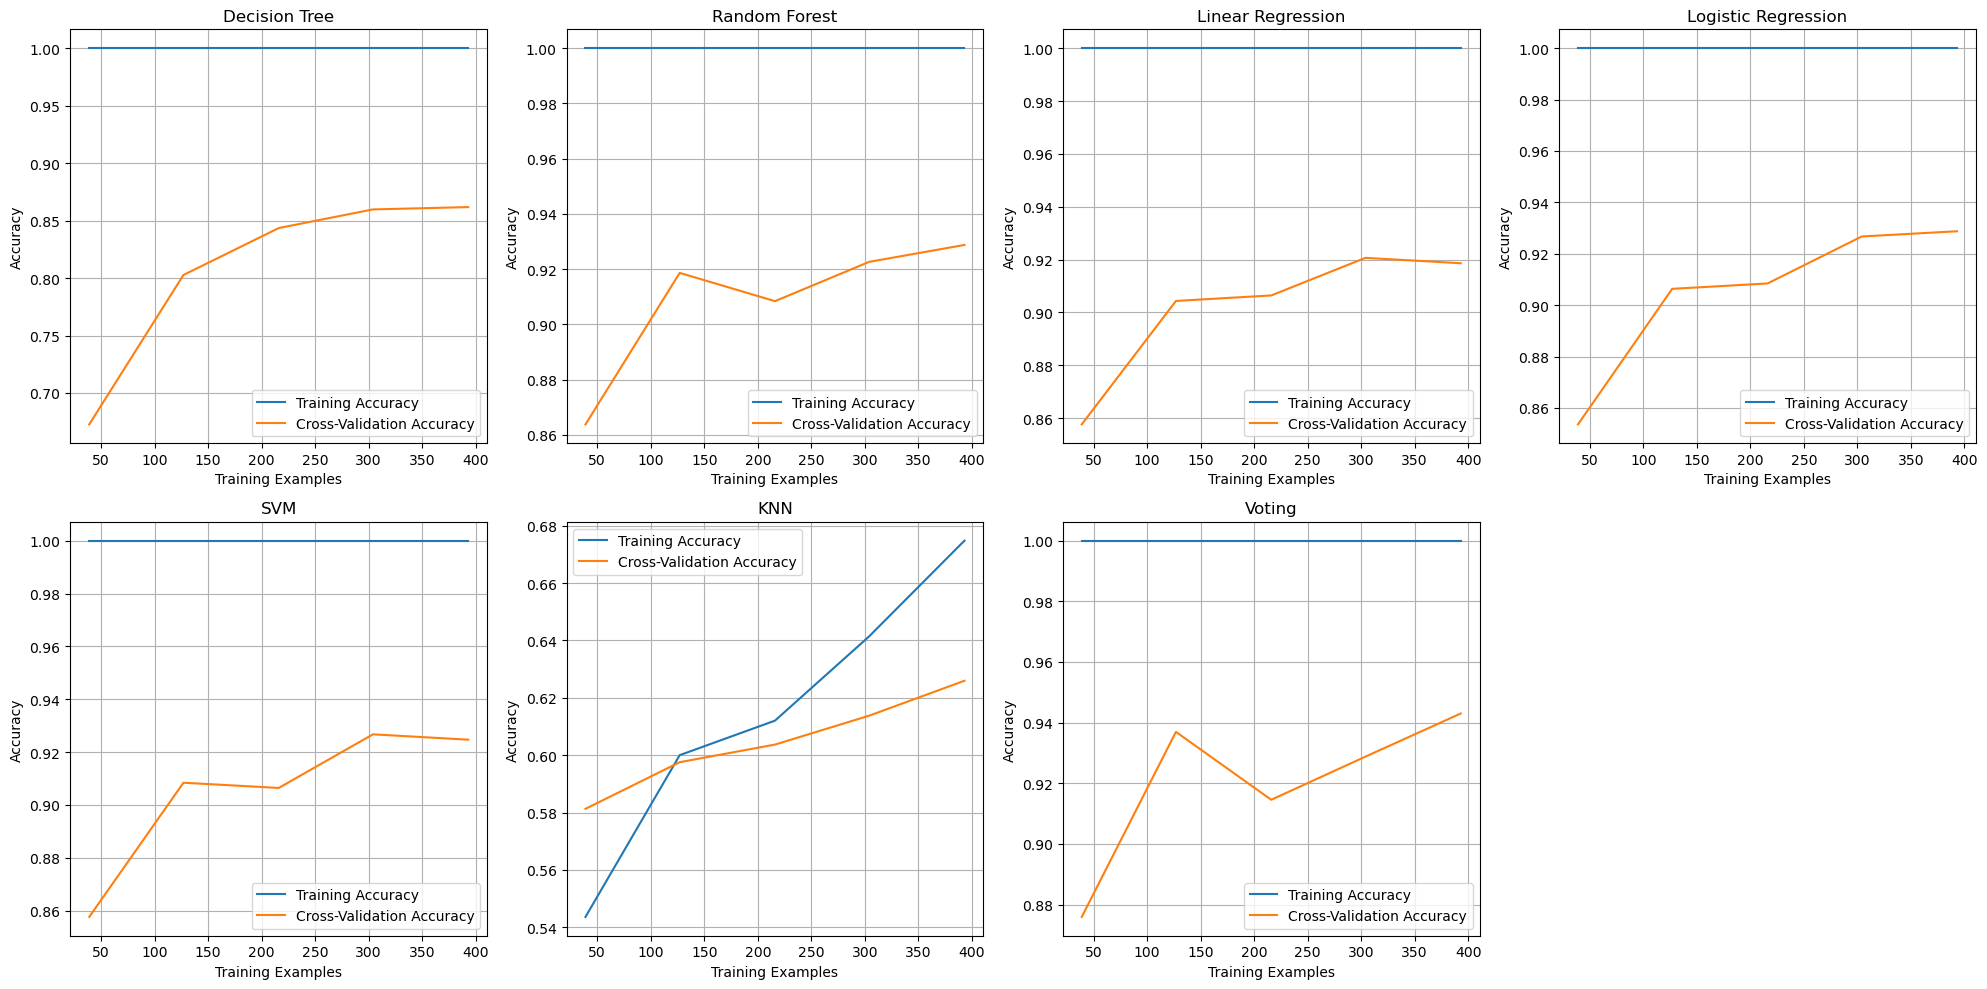

In [21]:
# Function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ax, train_sizes=np.linspace(0.1, 1.0, 5)):
    """ 
    Compute and plot the learning curve for a given estimator.
    
    Parameters:
    - estimator: the machine learning model
    - title: title for the plot
    - X, y: training features and labels
    - ax: matplotlib axes to plot on
    - train_sizes: fractions of the training set to use
    """
    # Compute learning curve data
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,  # Model to evaluate
        X, y,       # Features and labels
        cv=5,       # 5-fold cross-validation
        n_jobs=-1,  # Use all CPU cores
        train_sizes=train_sizes,  # Fractions of training data
        scoring='accuracy'        # Evaluate using accuracy
    )
    
    # Compute mean scores across folds
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    # Plot training and cross-validation accuracy
    ax.plot(train_sizes, train_scores_mean, label='Training Accuracy')
    ax.plot(train_sizes, test_scores_mean, label='Cross-Validation Accuracy')
    
    # Set plot labels and title
    ax.set_title(title)
    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Accuracy')
    
    # Display legend and grid
    ax.legend(loc='best')
    ax.grid(True)


# Create a 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

# Plot learning curves for various classifiers
plot_learning_curve(DecisionTreeClassifier(random_state=42), "Decision Tree", X_train, y_train, axes[0])
plot_learning_curve(RandomForestClassifier(n_estimators=100, random_state=42), "Random Forest", X_train, y_train, axes[1])
plot_learning_curve(LinearRegressionClassifier(), "Linear Regression", X_train, y_train, axes[2])
plot_learning_curve(LogisticRegression(max_iter=1000, random_state=42), "Logistic Regression", X_train, y_train, axes[3])
plot_learning_curve(SVC(kernel='linear', random_state=42), "SVM", X_train, y_train, axes[4])
plot_learning_curve(KNeighborsClassifier(n_neighbors=5), "KNN", X_train, y_train, axes[5])
plot_learning_curve(VotingClassifier(
    estimators=[('dt', DecisionTreeClassifier(random_state=42)),
                ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
                ('logreg', LogisticRegression(max_iter=1000, random_state=42))],
    voting='hard'
), "Voting", X_train, y_train, axes[6])

# Hide the unused last subplot (axes[7])
axes[7].axis('off')

plt.tight_layout()  # Adjust spacing between subplots
plt.show()          # Display the learning curves

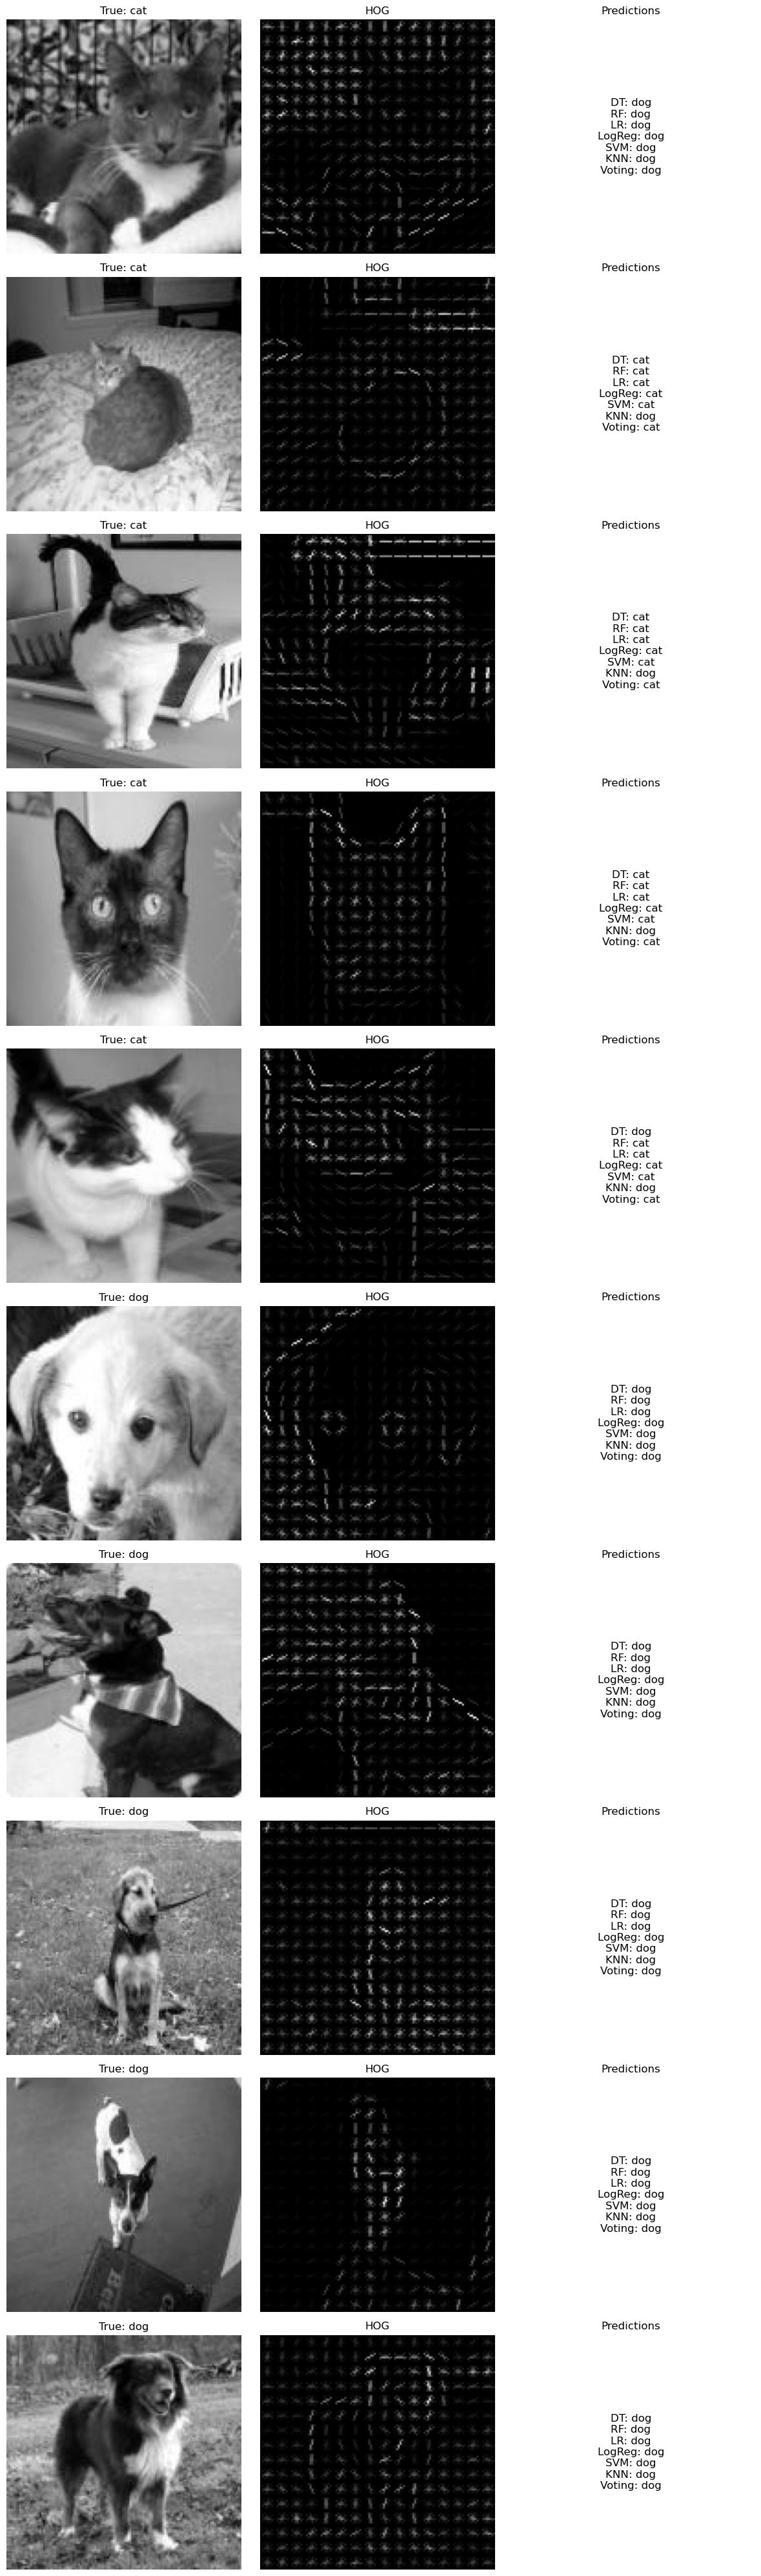

In [22]:
# Visualize sample results with multiple classifiers
classes = ['cat', 'dog']

# Select indices of test images for each class
cat_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 0]
dog_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 1]

# Take up to 5 samples per class
sample_indices = cat_indices[:min(5, len(cat_indices))] + dog_indices[:min(5, len(dog_indices))]

# Create subplot grid: rows = number of samples, columns = 3 (original, HOG, predictions)
fig, axes = plt.subplots(len(sample_indices), 3, figsize=(12, 4 * len(sample_indices)))

for i, idx in enumerate(sample_indices):
    test_idx = np.where(idx_test == idx)[0][0]  # Get actual index in test arrays
    true_label = y_test[test_idx]               # True class label

    # Get predictions from all models
    dt_label = dt_pred[test_idx]                # Decision Tree
    rf_label = rf_pred[test_idx]                # Random Forest
    lr_label = lr_pred[test_idx]                # Linear Regression
    logreg_label = logreg_pred[test_idx]        # Logistic Regression
    svm_label = svm_pred[test_idx]              # SVM
    knn_label = knn_pred[test_idx]              # KNN
    voting_label = voting_logreg_pred[test_idx] # Voting (Logistic)

    # Original Image
    ax = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    ax.imshow(images_test[test_idx], cmap='gray')
    ax.set_title(f'True: {classes[true_label]}')
    ax.axis('off')

    # HOG Image
    ax = axes[i, 1] if len(sample_indices) > 1 else axes[1]
    ax.imshow(hog_images_test[test_idx], cmap='gray')
    ax.set_title('HOG')
    ax.axis('off')

    # Predictions
    ax = axes[i, 2] if len(sample_indices) > 1 else axes[2]
    pred_text = (
        f"DT: {classes[dt_label]}\n"
        f"RF: {classes[rf_label]}\n"
        f"LR: {classes[lr_label]}\n"
        f"LogReg: {classes[logreg_label]}\n"
        f"SVM: {classes[svm_label]}\n"
        f"KNN: {classes[knn_label]}\n"
        f"Voting: {classes[voting_label]}"
    )
    ax.text(0.5, 0.5, pred_text, fontsize=12, ha='center', va='center')
    ax.set_title('Predictions')
    ax.axis('off')

plt.tight_layout()
plt.show()
